In [1]:
#import all necessary libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import matplotlib
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

from datetime import datetime
import yfinance as yf

from keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from keras.models import Sequential, load_model
import keras.backend as k
from keras.callbacks import EarlyStopping
from keras.src.optimizers import Adam
from keras.utils import plot_model

In [2]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end,actions=False)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.210007  162.960007  151.610001  161.020004  161.020004   
2024-08-06  161.710007  165.080002  158.539993  161.929993  161.929993   
2024-08-07  166.550003  167.580002  161.429993  162.770004  162.770004   
2024-08-08  165.169998  166.690002  162.550003  165.800003  165.800003   
2024-08-09  166.399994  168.550003  165.850006  166.940002  166.940002   
2024-08-12  168.139999  168.550003  166.110001  166.800003  166.800003   

               Volume company_name  
Date                                
2024-07-30   39508600       AMAZON  


In [3]:
# Describe the dataset statistically 
print(company_data['AAPL'].describe())

              Open         High          Low        Close    Adj Close  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean    140.630815   142.224877   139.157663   140.762186   139.011556   
std      41.853479    42.168244    41.547641    41.858028    42.250307   
min      50.255001    51.285000    49.917500    50.435001    48.803127   
25%     119.915001   121.177498   118.210001   119.920002   117.568810   
50%     147.095001   148.959999   145.739998   147.190002   145.398788   
75%     172.237495   173.832504   170.820007   172.565006   171.028076   
max     236.479996   237.229996   233.089996   234.820007   234.548523   

             Volume  
count  1.258000e+03  
mean   9.513718e+07  
std    5.202173e+07  
min    2.404830e+07  
25%    6.079935e+07  
50%    8.149215e+07  
75%    1.119894e+08  
max    4.265100e+08  


In [4]:
# Describe concisely the features,
# including the number of non-null values and data types
print(company_data['AAPL'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-08-13 to 2024-08-12
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1258 non-null   float64
 1   High          1258 non-null   float64
 2   Low           1258 non-null   float64
 3   Close         1258 non-null   float64
 4   Adj Close     1258 non-null   float64
 5   Volume        1258 non-null   int64  
 6   company_name  1258 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.6+ KB
None


In [5]:
# Displaying rows and columns for the complete dataset
print("Dimensions of the Data:", df.shape)

Dimensions of the Data: (5032, 7)


In [6]:
# Displaying rows and columns for Apple
print("Dimensions of the Data:", company_data['AAPL'].shape)

Dimensions of the Data: (1258, 7)


In [7]:
# Displaying rows and columns for Google
print(company_data['GOOG'].info())

# Describe concisely the features,
# including the number of non-null values and data types for Google 
print("Dimensions of the Data:", company_data['GOOG'].shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-08-13 to 2024-08-12
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1258 non-null   float64
 1   High          1258 non-null   float64
 2   Low           1258 non-null   float64
 3   Close         1258 non-null   float64
 4   Adj Close     1258 non-null   float64
 5   Volume        1258 non-null   int64  
 6   company_name  1258 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.6+ KB
None
Dimensions of the Data: (1258, 7)


In [8]:
# Data Cleaning 
# Handling Missing Values 

# Checking and printing for Missing Values (NaN) in the datasets
print("Are there any missing points in the dataset?:", df.isnull().values.any(), "\n")

Are there any missing points in the dataset?: False 



In [9]:
# Handling Duplicate Values:
# Checking and printing for duplicated rows in the DataFrame
print("Number of Duplicated Rows:", df.duplicated().sum(), "\n")

Number of Duplicated Rows: 0 



In [10]:
# No need to remove duplicated and recheck 
# for dimensions because there are no duplicate

In [11]:
data = company_data['AAPL']
#data = df 
# Prepare features and target
data['Target'] = data['Close'].shift(-1)  # Predict next day's price
data = data.dropna()
X = data[['Close']]
y = data['Target']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Verify the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 754
Validation set size: 251
Test set size: 252


<Axes: >

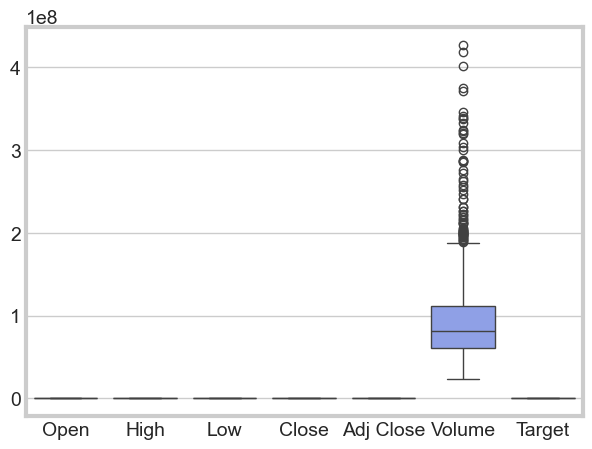

In [12]:
sns.boxplot(data)

In [13]:
# Example DataFrame
data = df

# Ensure the data is numeric
numeric_data = data.select_dtypes(include=[np.number])

# Calculate z-scores
z_scores = stats.zscore(numeric_data)

# Identify outliers
outliers = (np.abs(z_scores) > 3)
            
# Print outliers
print("Outlier rows (True indicates an outlier):")
print(outliers)

Outlier rows (True indicates an outlier):
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2019-08-13  False  False  False  False      False    True
2019-08-14  False  False  False  False      False   False
2019-08-15  False  False  False  False      False   False
2019-08-16  False  False  False  False      False   False
2019-08-19  False  False  False  False      False   False
...           ...    ...    ...    ...        ...     ...
2024-08-06  False  False  False  False      False   False
2024-08-07  False  False  False  False      False   False
2024-08-08  False  False  False  False      False   False
2024-08-09  False  False  False  False      False   False
2024-08-12  False  False  False  False      False   False

[5032 rows x 6 columns]


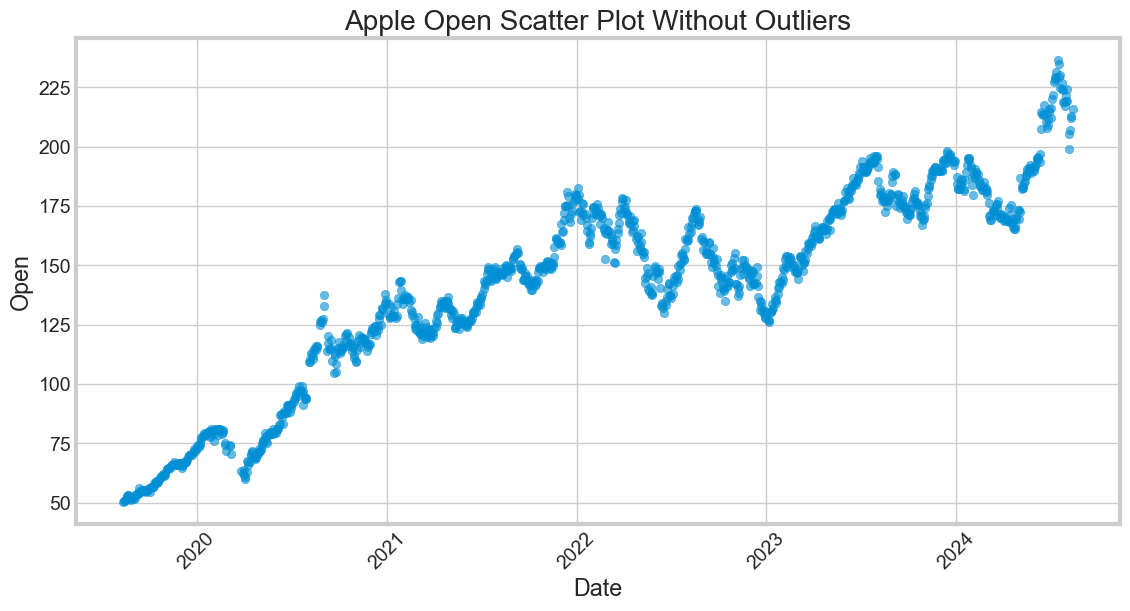

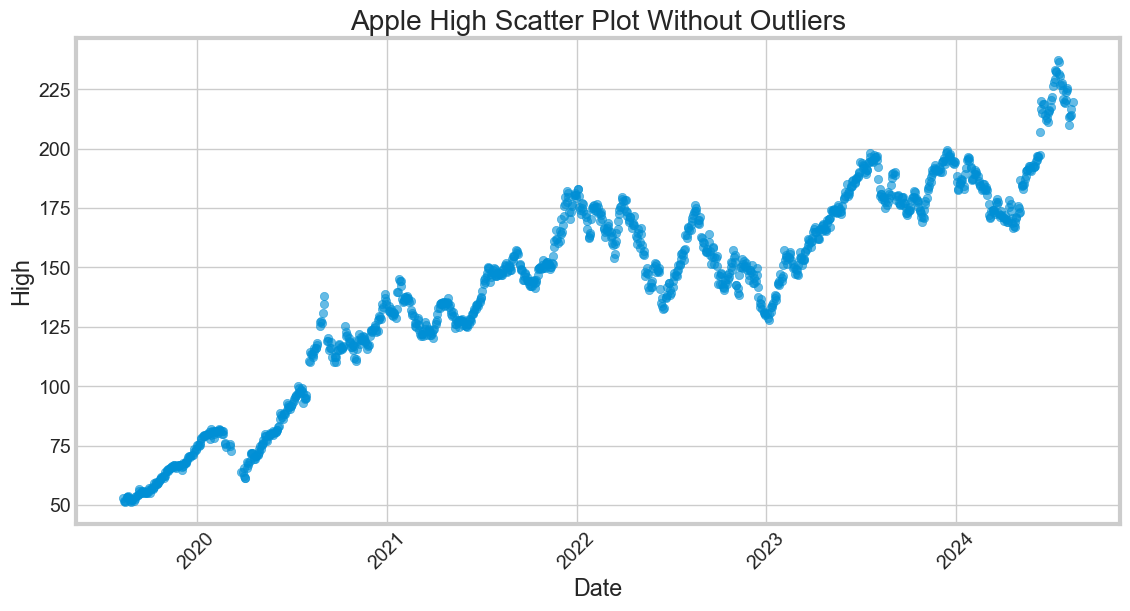

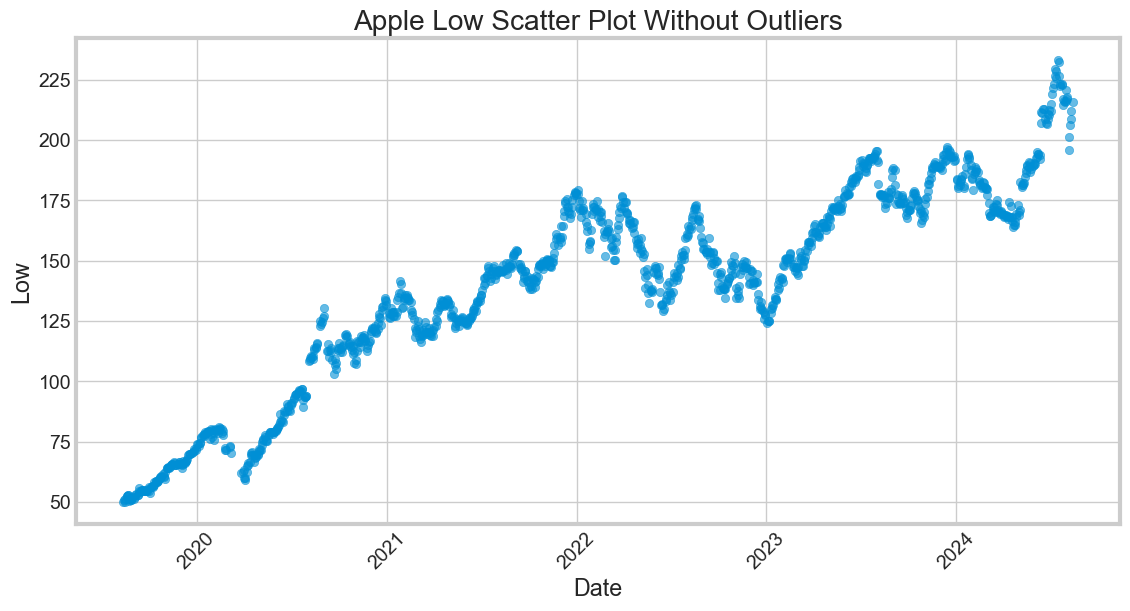

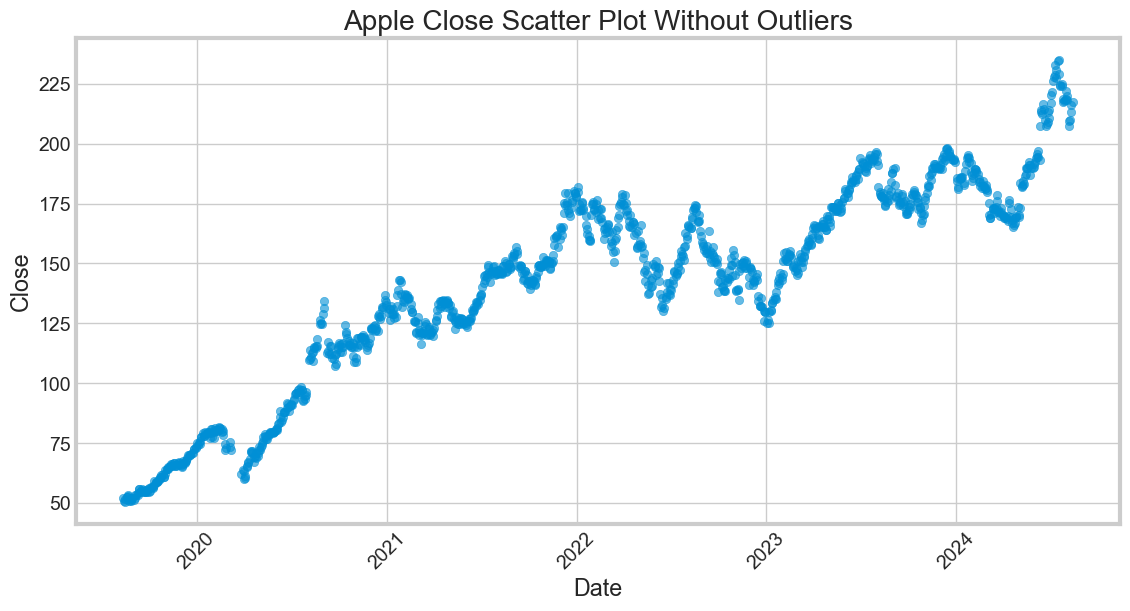

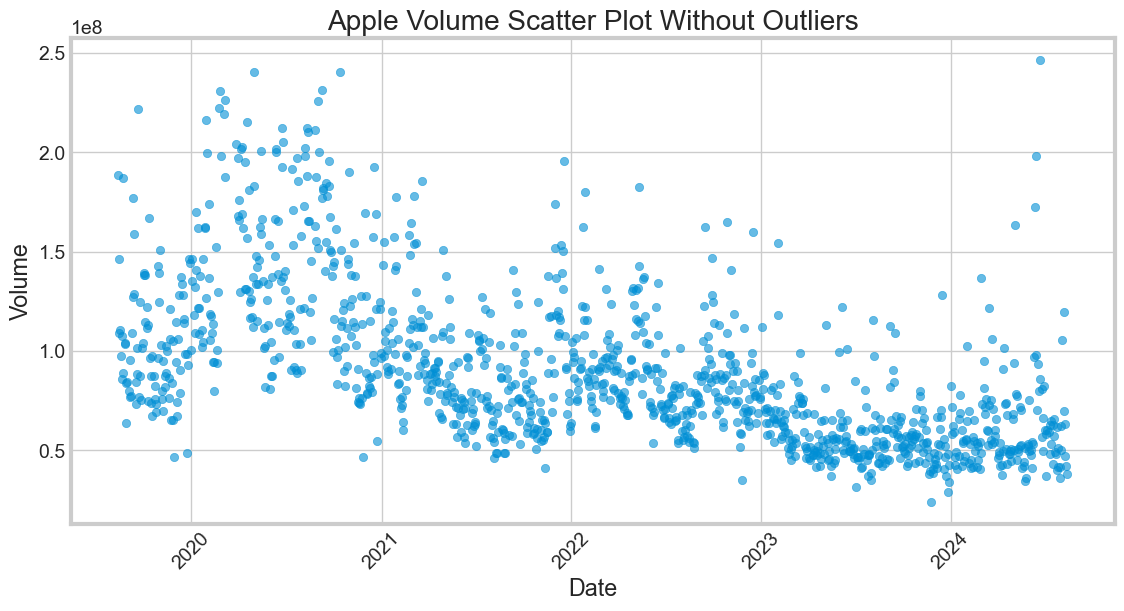

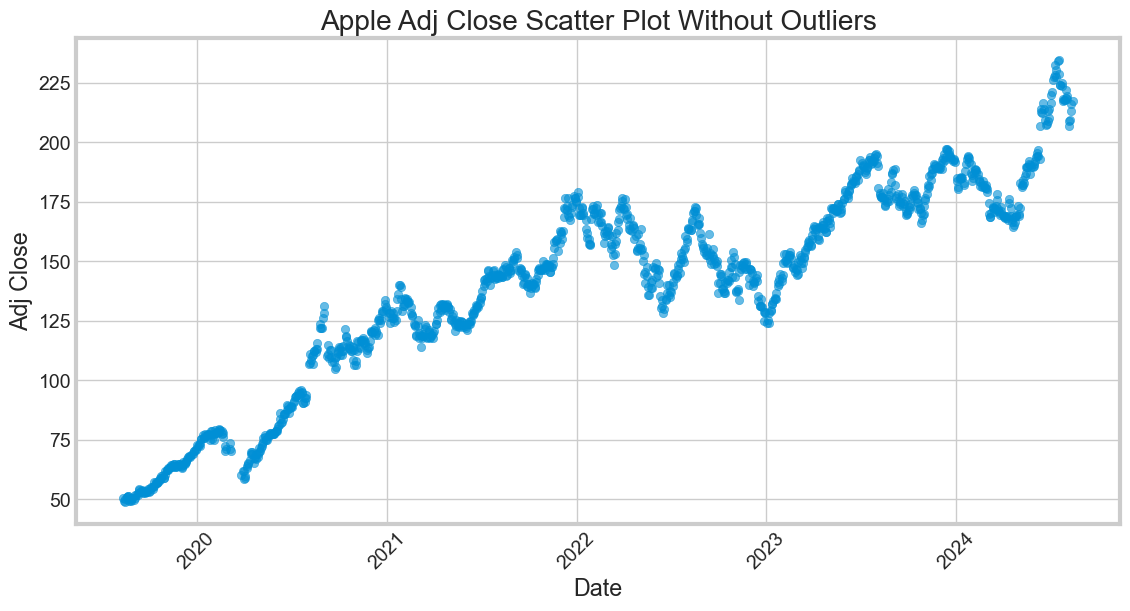

In [14]:
data = company_data['AAPL']
columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
data = data[columns_to_keep]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

#handle outliers with a method
def remove_outliers(df):
    z_scores = stats.zscore(df.select_dtypes(include=[np.number]))
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

#use the method for the company
data_cleaned=remove_outliers(data)

numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

#show the results
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(data_cleaned.index, data_cleaned[column], alpha=0.6)
    plt.title(f'Apple {column} Scatter Plot Without Outliers')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.show()
#print(data_cleaned.tail(10))

In [15]:
# Display the first few rows of the dataset to understand its structure
print("First 5 rows of the dataset:")
data_cleaned.head()

First 5 rows of the dataset:


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2019-08-13,50.255001,53.035000,50.119999,52.242500,188874000,50.552147
2019-08-14,50.790001,51.610001,50.647499,50.687500,146189600,49.047455
2019-08-15,50.865002,51.285000,49.917500,50.435001,108909600,48.803127
2019-08-16,51.070000,51.790001,50.959999,51.625000,110481600,49.954624
2019-08-19,52.654999,53.182499,52.507500,52.587502,97654400,50.885986


In [16]:
# Display the last few rows of the dataset to understand its structure
print("Last 5 rows of the dataset:")
data_cleaned.tail()

Last 5 rows of the dataset:


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2024-08-06,205.300003,209.990005,201.070007,207.229996,69660500,206.990402
2024-08-07,206.899994,213.639999,206.389999,209.820007,63516400,209.577423
2024-08-08,213.110001,214.199997,208.830002,213.309998,47161100,213.063385
2024-08-09,212.100006,216.779999,211.970001,216.240005,42201600,215.990005
2024-08-12,216.070007,219.509995,215.600006,217.529999,37992400,217.529999


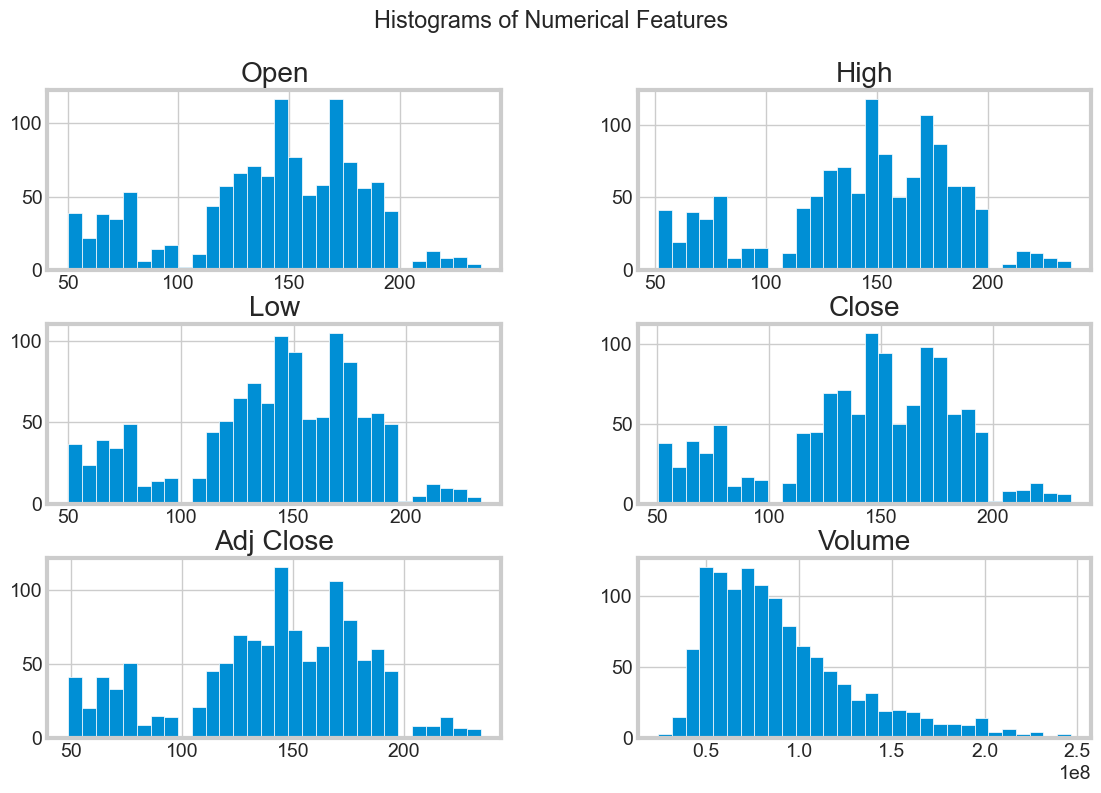

In [17]:
# Visualize the distribution of numerical features
numerical_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data_cleaned[numerical_features].hist(bins=30, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.show()
#The graphs for Open/High/Low/Close/Adj Close show us a similar pattern:
#The stocks were usually sold at around 150, 
#Volume wise we see its mostly at around 60 

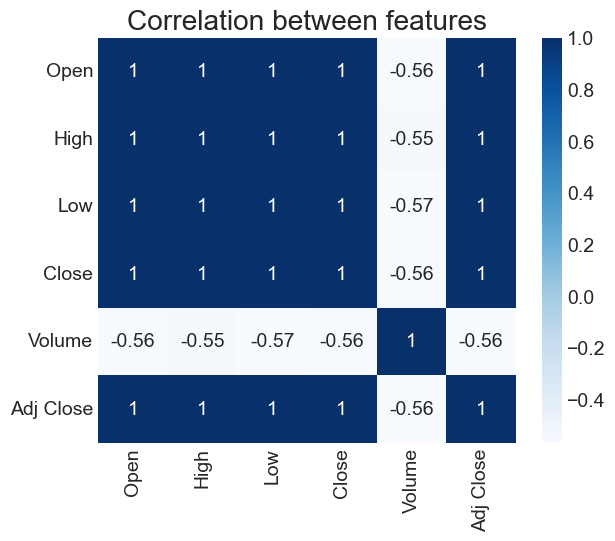

In [18]:
# A higher (darker) value represents higher correlation between the variables
# A lower (lighter) value represents lower correlation between the variables

plt.figure(figsize=(6,5))
#data_disp = df.drop('company_name', axis=1)
plt.title("Correlation between features")
sns.heatmap(data_cleaned.corr(), cmap='Blues', annot=True);

# There's a high correlation between 5 of the features (Open, High, Low, Close, Adj Close)
# There's a negative correlation between those features and the volume

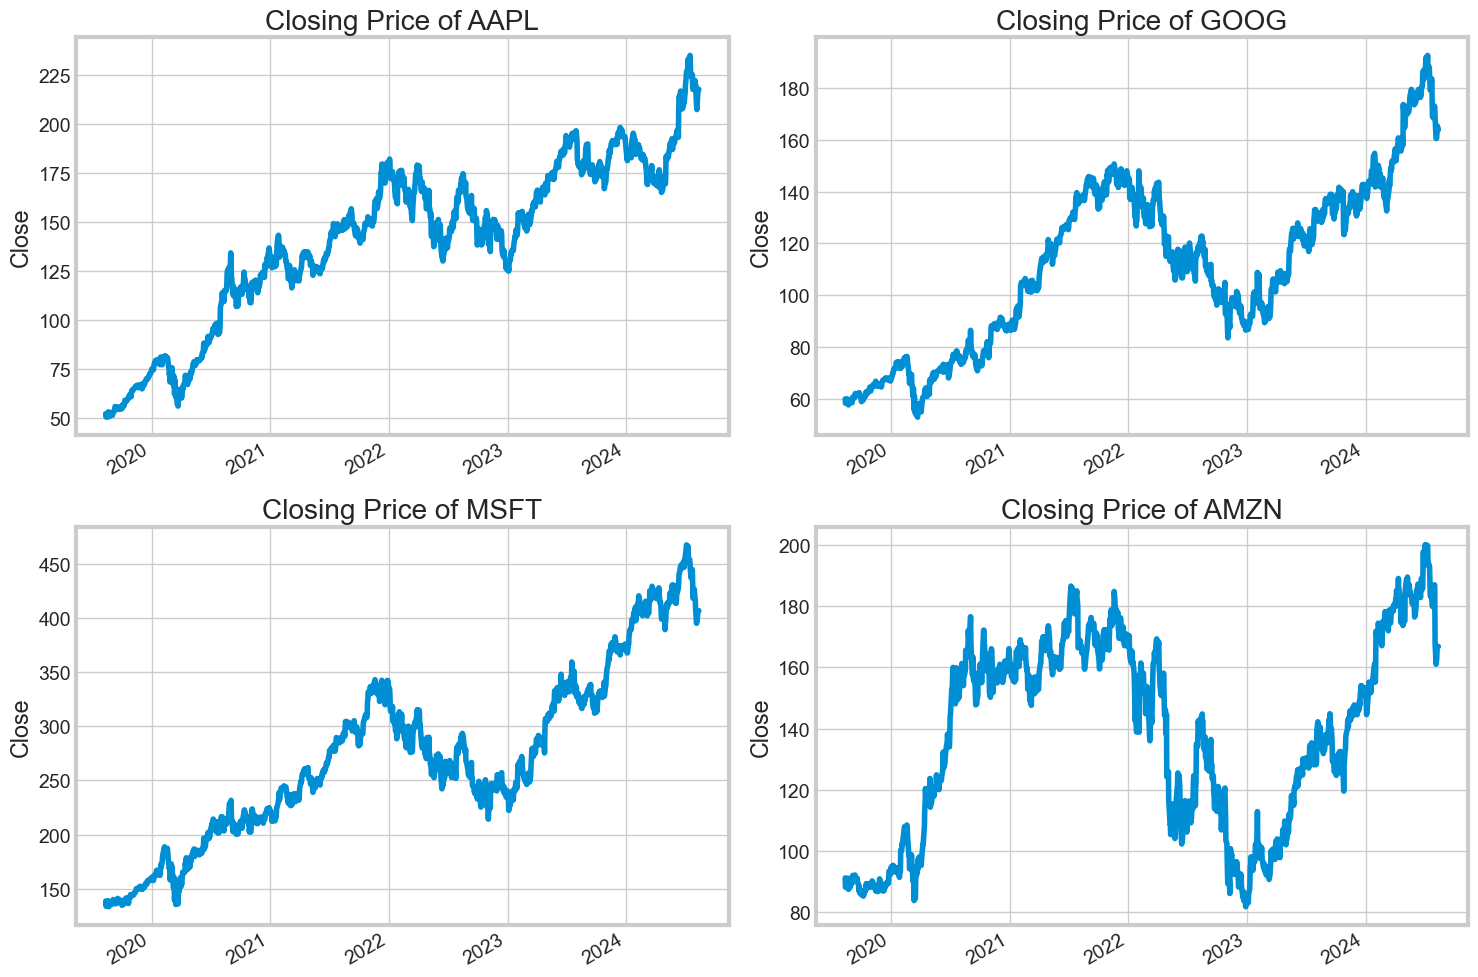

In [19]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Close'].plot()
    plt.ylabel('Close')
    plt.xlabel('')
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

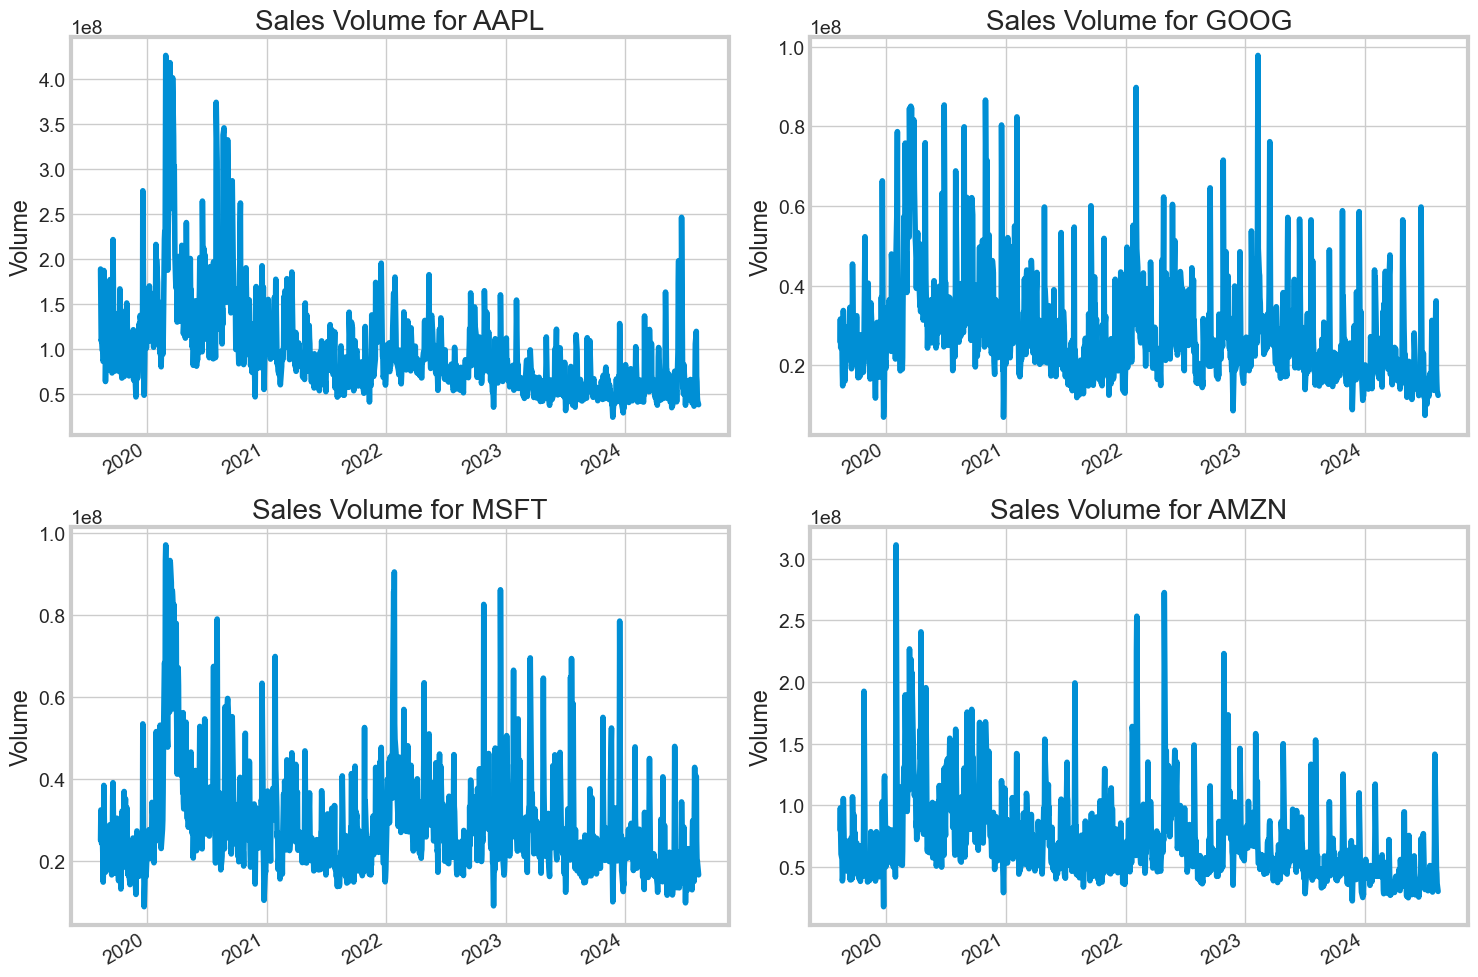

In [20]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel('')
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()
#looks like volume increases monthly (or periodically)

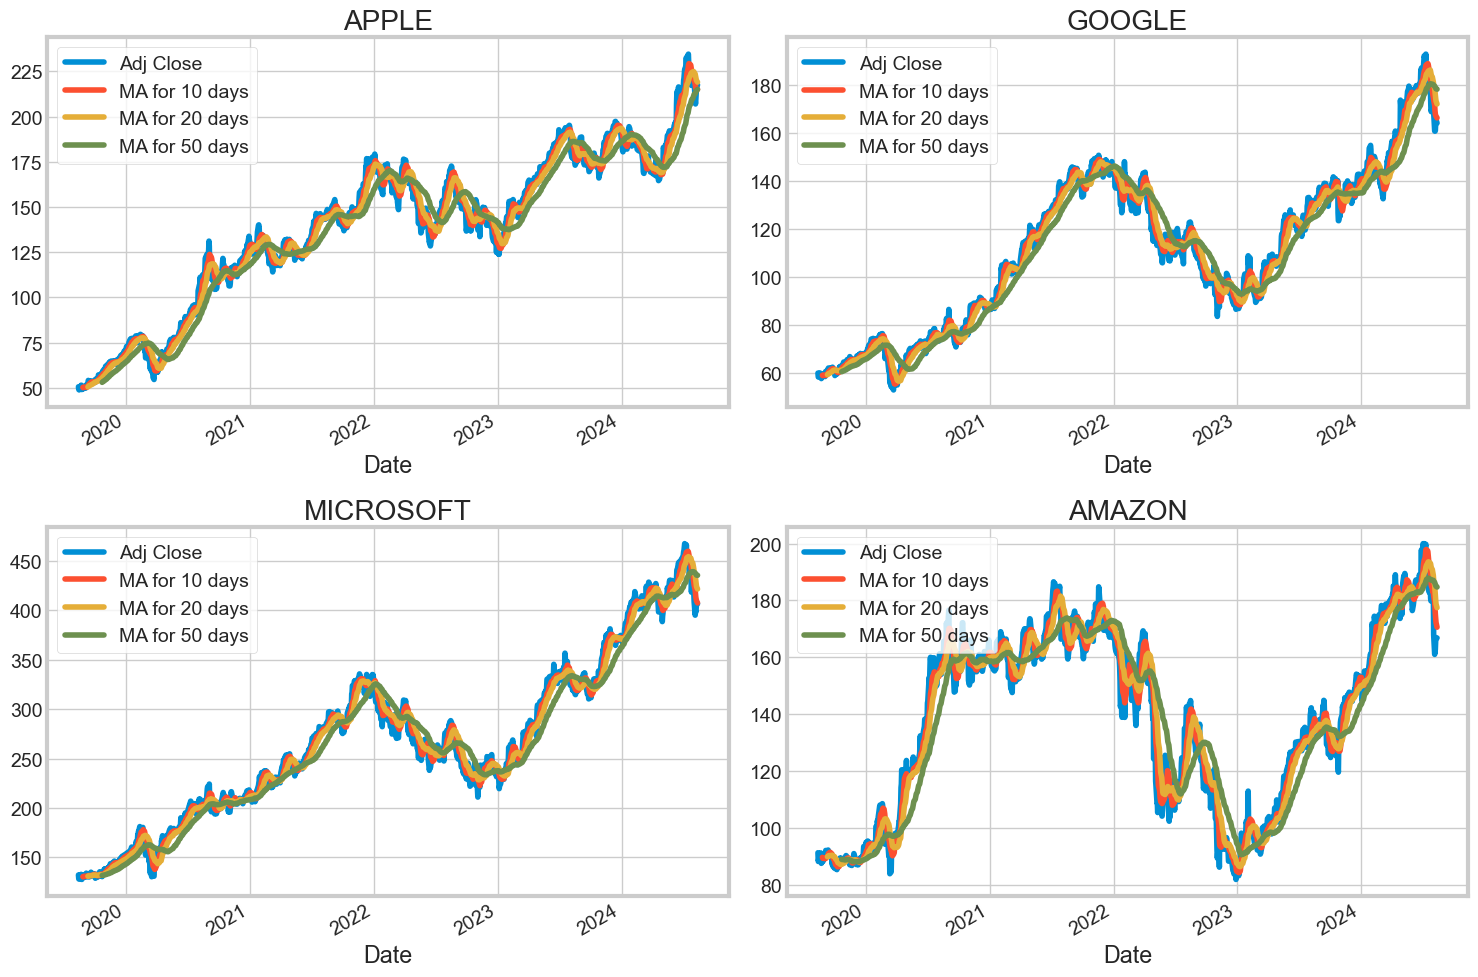

In [21]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

company_data['AAPL'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

company_data['GOOG'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

company_data['MSFT'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

company_data['AMZN'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()
#best value to measure is 10-20 days: captures trends w/out noise

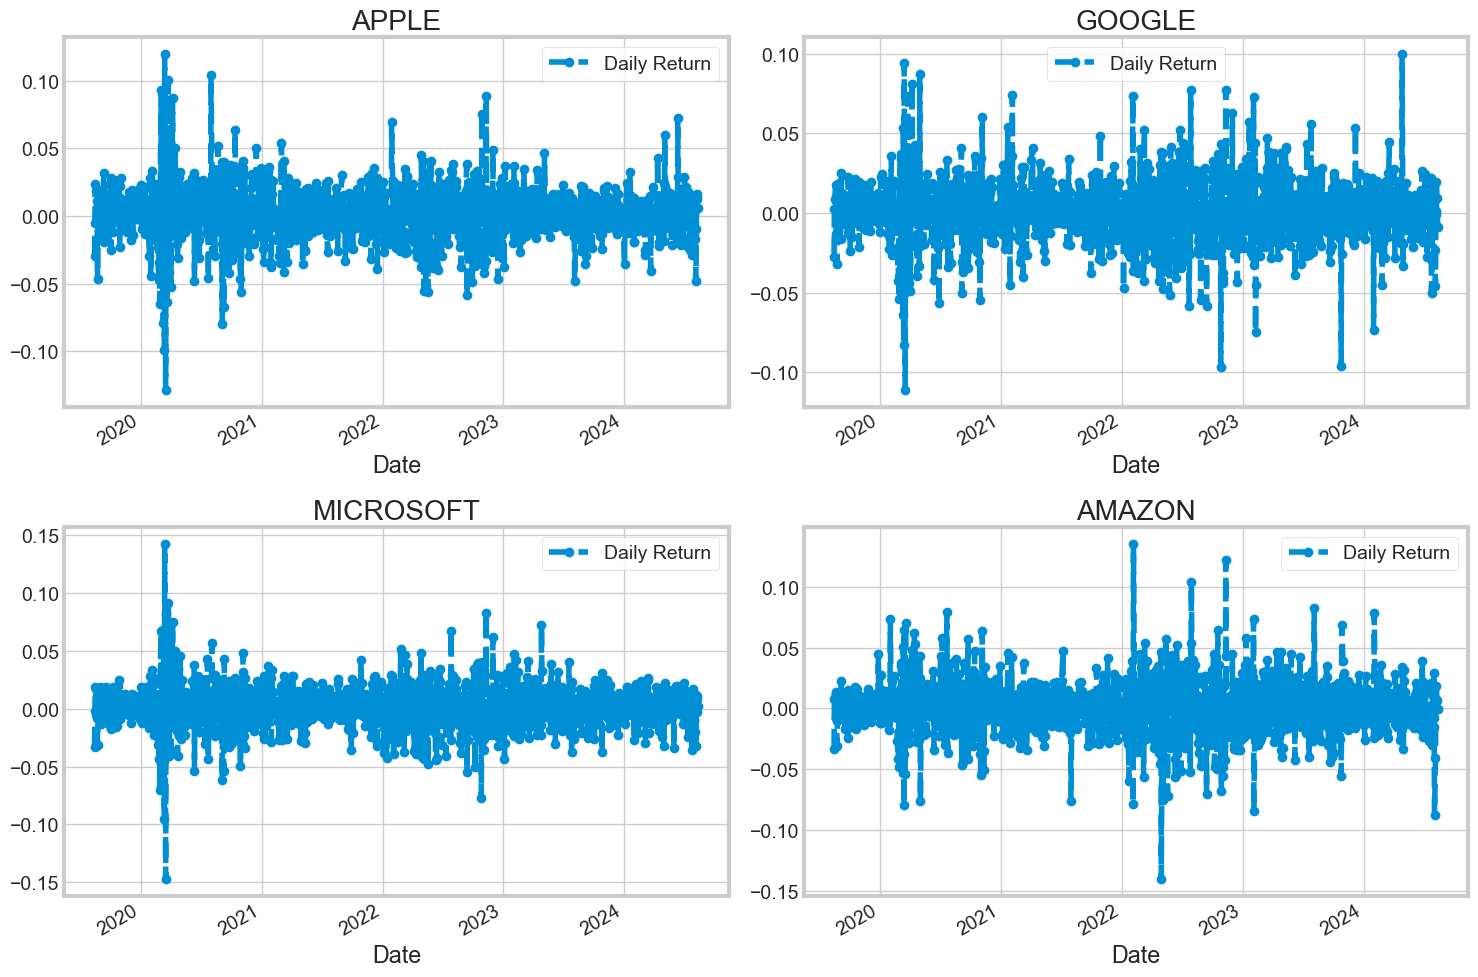

In [22]:
# What was the daily return of the stock on average?
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

company_data['AAPL']['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

company_data['GOOG']['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

company_data['MSFT']['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

company_data['AMZN']['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

#Harder to interpret, but it easily highlights when the daily returns were really high/low


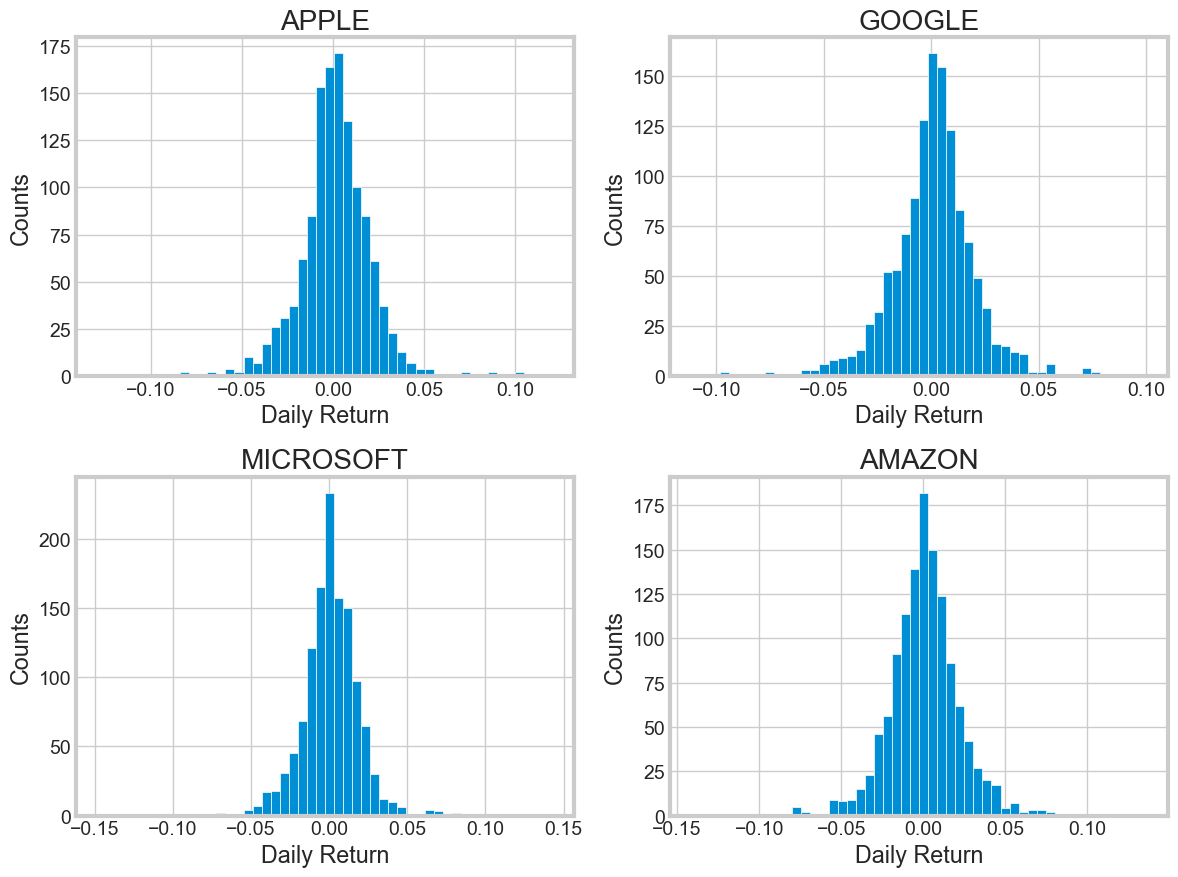

In [23]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()
#Allows us to see how risky a stock is
#How likely is the stock to lose/gain value and by how much
#Google looks to have gained the most at once
#However, Apple seems to be the best probabilities 

In [24]:
#4. What was the correlation between different stocks closing prices?
# Grab all the closing prices for the tech stock list into one DataFrame
close_prices = pd.DataFrame({tech_list[i]: company['Close'] for i, company in enumerate(company_list)})

# Make a new tech returns DataFrame
tech_rets = close_prices.pct_change()
tech_rets.head()

,AAPL,GOOG,MSFT,AMZN
Date,,,,
2019-08-13,NaN,NaN,NaN,NaN
2019-08-14,-0.029765,-0.027546,-0.033333,-0.033645
2019-08-15,-0.004981,0.002551,-0.002239,0.007465
2019-08-16,0.023595,0.008858,0.018327,0.009262
2019-08-19,0.018644,0.017705,0.016749,0.013138


<Figure size 600x500 with 0 Axes>

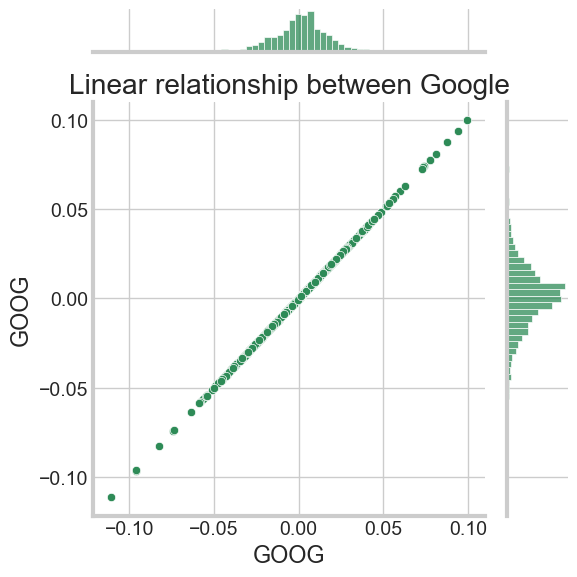

In [25]:
# Comparing Google to itself should show a perfectly linear relationship
plt.figure(figsize=(6, 5))

sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

plt.title("Linear relationship between Google")
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

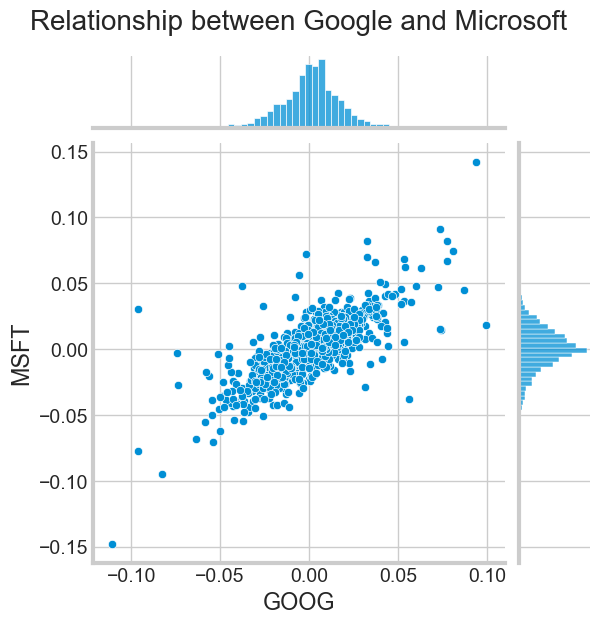

In [26]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
plt.figure(figsize=(10, 10))

sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

plt.title("Relationship between Google and Microsoft", fontsize=20,y=1.25)
plt.show()

<Figure size 3600x3600 with 0 Axes>

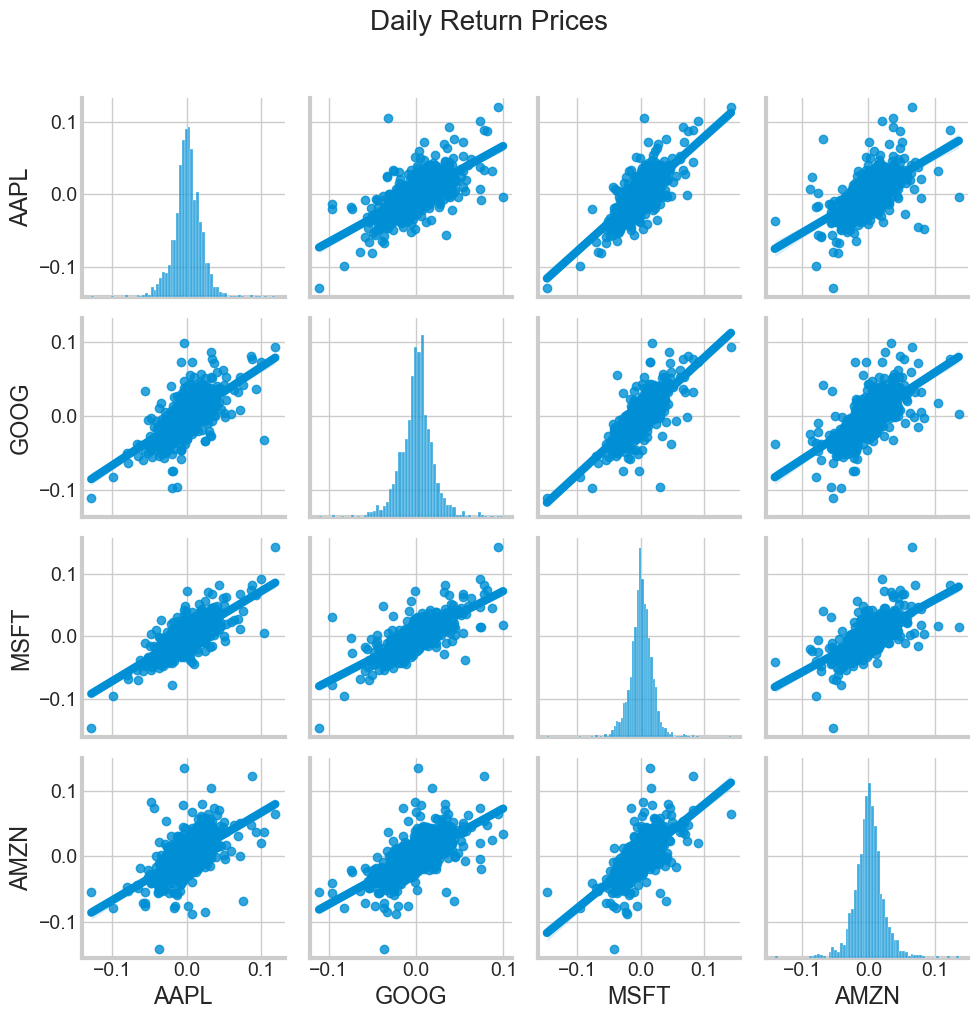

In [27]:
# We can simply call pair plot on our DataFrame for an automatic visual analysis 
# of all the comparisons
plt.figure(figsize=(36, 36))

sns.pairplot(tech_rets, kind='reg')

plt.suptitle("Daily Return Prices", fontsize=20,y=1.02) 
plt.tight_layout()
plt.show()
#Most correlation (daily return) between google and amazon

<Figure size 3600x3000 with 0 Axes>

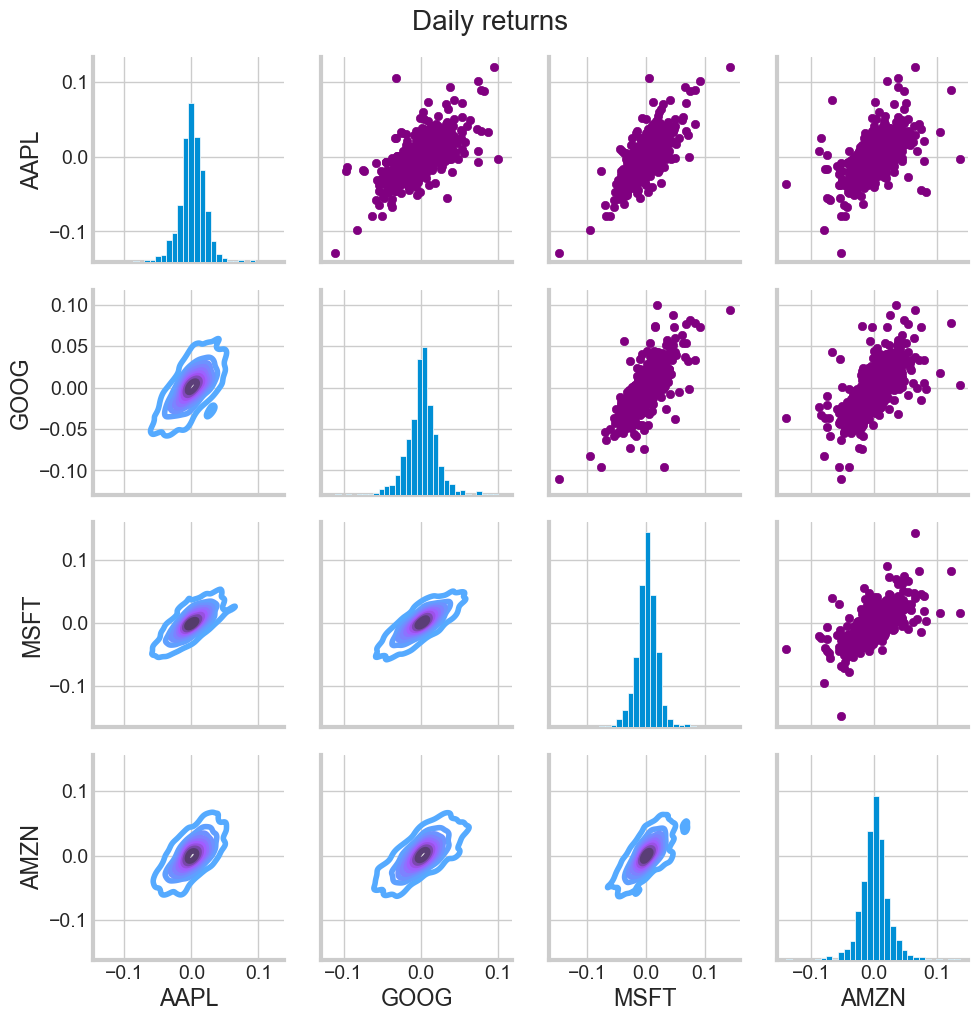

In [28]:
plt.figure(figsize=(36, 30))

# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, including the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

plt.title("Daily returns",fontsize=20,x=-1.50,y=4.5)
#plt.tight_layout()
plt.show()

#If a density curve is left skewed, then the mean is less than the median.
#If a density curve is right skewed, then the mean is greater than the median.
#Microsoft and Google have the best correlation (daily return) once again.

<Figure size 3600x3000 with 0 Axes>

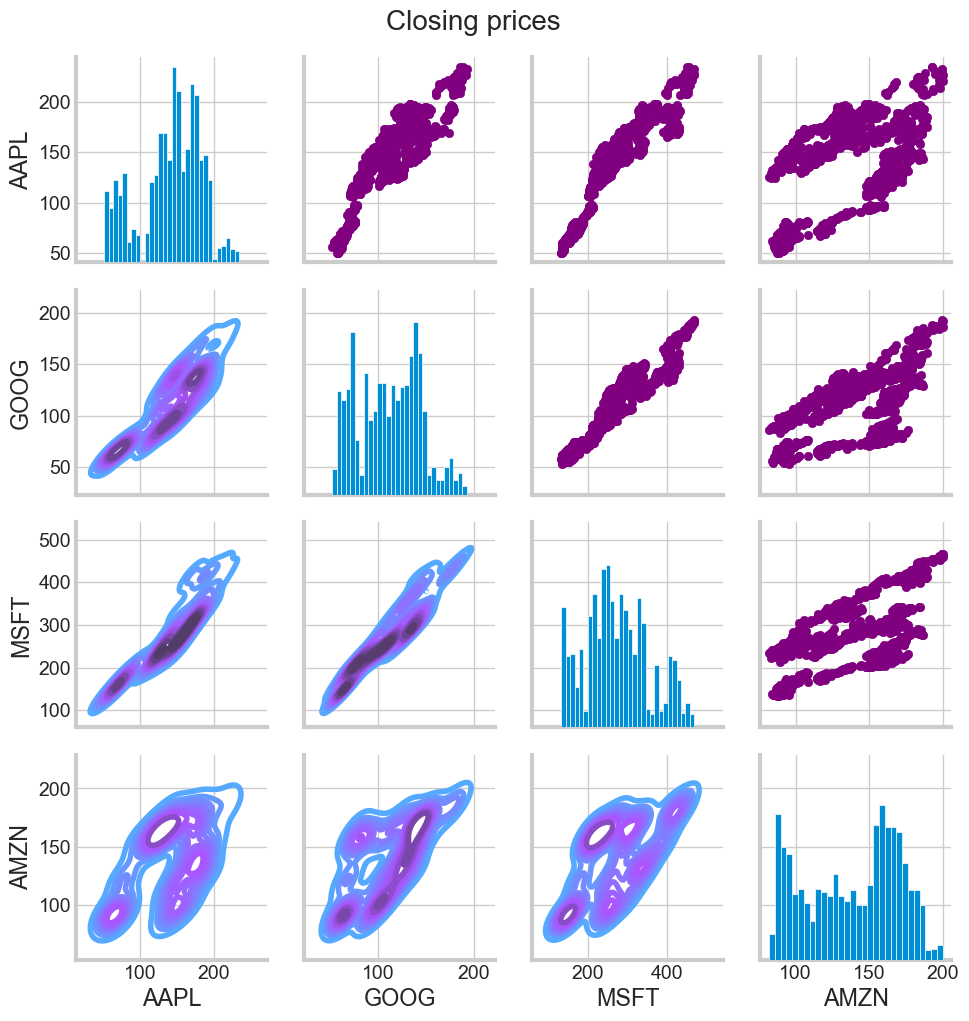

In [29]:
plt.figure(figsize=(36, 30))

# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(close_prices)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

plt.title("Closing prices",fontsize=20,x=-1.50,y=4.5)
plt.show()

#If a density curve is left skewed, then the mean is less than the median.
#If a density curve is right skewed, then the mean is greater than the median.
#It's clear that Microsoft and Amazon are the best correlated for closing prices

Text(0.5, 1.0, 'Correlation of stock closing price')

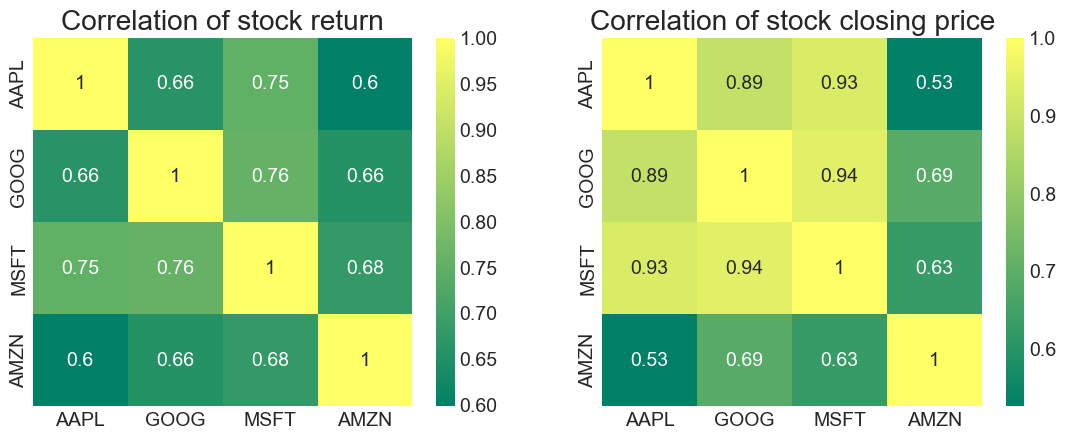

In [30]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer', color='purple')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(close_prices.corr(), annot=True, cmap='summer', color='purple')
plt.title('Correlation of stock closing price')
#There's a high correlation between AAPL and MSFT second to GOOG and MSFT

In [31]:
# Calculate percentage returns
tech_rets = close_prices.pct_change().dropna()

# Calculate standard deviation of adjusted close prices
std_dev_closing = close_prices.std()

# Calculate standard deviation of returns
std_dev_rets = tech_rets.std()

# Display the standard deviations
print("Standard Deviation of Closing Prices (last 5 years):")
print(std_dev_closing)
print("\nStandard Deviation of Daily Returns (last 5 years):")
print(std_dev_rets)

Standard Deviation of Closing Prices (last 5 years):
AAPL    41.858028
GOOG    32.327000
MSFT    79.971274
AMZN    31.590496
dtype: float64

Standard Deviation of Daily Returns (last 5 years):
AAPL    0.020049
GOOG    0.020070
MSFT    0.019134
AMZN    0.022308
dtype: float64


In [32]:
#Set Target Variableth
#Can filter close either or way
#output_var = pd.DataFrame(data_cleaned, columns=['Close']) 
Target = data_cleaned.filter(['Close'])

#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']
Target.tail

<bound method NDFrame.tail of                  Close
Date                  
2019-08-13   52.242500
2019-08-14   50.687500
2019-08-15   50.435001
2019-08-16   51.625000
2019-08-19   52.587502
...                ...
2024-08-06  207.229996
2024-08-07  209.820007
2024-08-08  213.309998
2024-08-09  216.240005
2024-08-12  217.529999

[1230 rows x 1 columns]>

In [33]:
#Scaling
scaler = MinMaxScaler(feature_range= (0,1))
feature_transform = scaler.fit_transform(data_cleaned[features])
feature_transform = pd.DataFrame(columns = features, data = feature_transform, index = data_cleaned.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2019-08-13,0.000000,0.009411,0.001106,0.741212
2019-08-14,0.002873,0.001748,0.003985,0.549263
2019-08-15,0.003276,0.000000,0.000000,0.381617
2019-08-16,0.004376,0.002716,0.005691,0.388686
2019-08-19,0.012888,0.010205,0.014140,0.331003


In [34]:
#Splitting to Training, Testing and Validation set
timesplit = TimeSeriesSplit(n_splits=10)

for train_index, test_index in timesplit.split(feature_transform):
    # Define the training and testing sets
    X_train = feature_transform[:len(train_index)]
    X_test = feature_transform[len(train_index): (len(train_index) + len(test_index))]
    y_train = Target[:len(train_index)].values.ravel()
    y_test =Target[len(train_index): (len(train_index) + len(test_index))].values.ravel()
    
     # Further split the training set into training and validation sets
    
    split_ratio = 0.8 # Example: 80% of the training data for training, 20% for validation
    split_point = int(len(X_train) * split_ratio)
    
    X_train_temp = X_train[:split_point]
    X_val = X_train[split_point:]
    
    y_train_temp = y_train[:split_point]
    y_val = y_train[split_point:]    
    # The Data is now split into training, validation and testing sets  
    print("Shape of feature_transform:", feature_transform.shape)
    
print("Shape after split - X_train:", X_train.shape)
print("Shape after split - X_val and X_train_temp:", X_val.shape, X_train_temp.shape)
print("Shape after split - X_test:", X_test.shape)


Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape of feature_transform: (1230, 4)
Shape after split - X_train: (1119, 4)
Shape after split - X_val and X_train_temp: (224, 4) (895, 4)
Shape after split - X_test: (111, 4)


In [35]:
# Process the data for LSTM, turn them into np arrays
trainX = np.array(X_train_temp)
valX = np.array(X_val)
testX = np.array(X_test)


# Reshape them into 3D format
X_train_final = trainX.reshape(X_train_temp.shape[0], 1, X_train_temp.shape[1])
X_val_final = valX.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_final = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

print('Final X training set: ', X_train_final)

Final X training set:  [[[0.         0.00941139 0.00110551 0.7412124 ]]

 [[0.00287287 0.00174783 0.00398531 0.54926293]]

 [[0.00327561 0.         0.         0.38161675]]

 ...

 [[0.59693919 0.59557935 0.60141399 0.10643643]]

 [[0.60193319 0.59735407 0.60376146 0.10610951]]

 [[0.59586523 0.59574068 0.59977617 0.11730196]]]


In [36]:
model = Sequential()
model.add(Input(shape = (1, trainX.shape[1])))
model.add(LSTM(units= 128, return_sequences = True, activation = 'relu'))

model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences = False))

model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer = 'adam', loss = mean_absolute_error)

plot_model(model, show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'